In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.naive_bayes import GaussianNB

#Metrics
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
random_state = 42

In [79]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Data Preprocessing

### Handling Missing Values

In [80]:
# Remove rows with missing values in 'MasVnrType', 'MasVnrArea', and 'Electrical' columns.
df.dropna(subset=['MasVnrType', 'MasVnrArea', 'Electrical'], inplace=True)

In [81]:
# Impute missing LotFrontage values based on the median LotFrontage within each neighborhood.
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [82]:
# Fill missing values in FireplaceQu with 'None'.
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

In [83]:
# Fill missing values in garage-related variables with 'None'.
df['GarageType'] = df['GarageType'].fillna('None')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('None')

In [84]:
# Fill missing values in basement-related variables with 'None'.
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')

In [85]:
# Drop columns with a high count of missing values
df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

### Encoding

In [86]:
nominalFeatures = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                    'Heating', 'CentralAir', 'Electrical', 'GarageType', 'SaleType',
                    'SaleCondition','PavedDrive']

ordinalFeatures = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual','FireplaceQu',
                    'GarageQual', 'GarageCond']

otherOrdinalFeatures = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish']

In [87]:
df = pd.get_dummies(df, columns = nominalFeatures)

In [88]:
ordinalCategories = [['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'] for _ in ordinalFeatures]

ordinalEncoder = OrdinalEncoder(categories=ordinalCategories)
ordinalEncoded = ordinalEncoder.fit_transform(df[ordinalFeatures])

for i, feature in enumerate(ordinalFeatures):
    df[feature] = ordinalEncoded[:, i]

In [89]:
encodingCategories = [
    ['None', 'No', 'Mn', 'Av', 'Gd'],  # BsmtExposure
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType1
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType2
    ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], # Functional
    ['None', 'Unf', 'RFn', 'Fin']  # GarageFinish
]

ordinalEncoder = OrdinalEncoder(categories=encodingCategories)
ordinalEncoded = ordinalEncoder.fit_transform(df[otherOrdinalFeatures])

for i, feature in enumerate(otherOrdinalFeatures):
    df[feature] = ordinalEncoded[:, i]

### Splitting DataSet

In [90]:
df_cp = df.copy()
y = df_cp.pop('SalePrice')
X = df_cp

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=random_state)

In [92]:
print(X_train.shape)
print(X_test.shape)

(1160, 224)
(291, 224)


In [93]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 1295 to 1132
Columns: 224 entries, Id to PavedDrive_Y
dtypes: float64(17), int64(34), uint8(173)
memory usage: 667.2 KB


In [94]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291 entries, 540 to 1310
Columns: 224 entries, Id to PavedDrive_Y
dtypes: float64(17), int64(34), uint8(173)
memory usage: 167.4 KB


## Gaussian Model

In [95]:
gaussian = GaussianNB()
gaussian.fit(X_train,y_train)
y_pred = gaussian.predict(X_test)

In [96]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))
print("------------------------------------------------")

MSE: 1744685739.2920961
MAE: 24327.16151202749
R²: 0.6872796060643597
------------------------------------------------


Este resultado indica que el modelo es capaz de explicar el 69% de la variabilidad observada en la variable de respuesta, lo cual es una señal de una buena capacidad predictiva bajo este contexto.

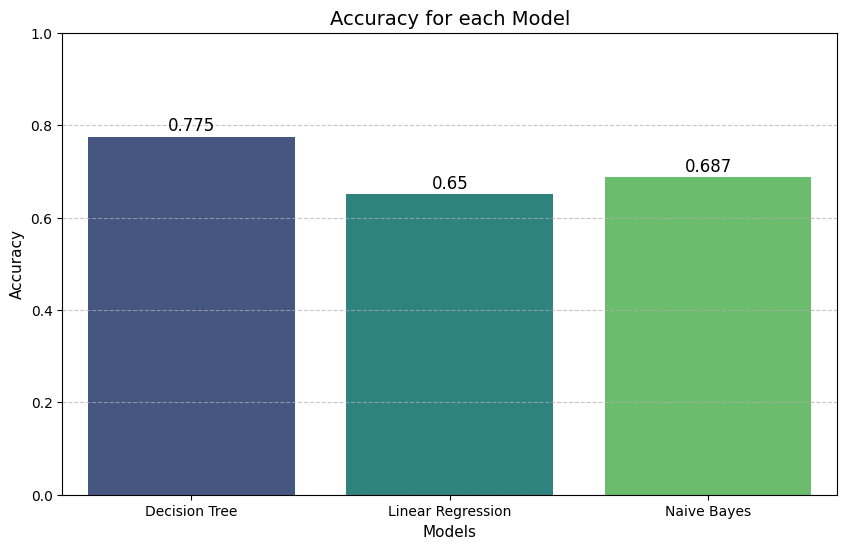

In [97]:
# Data for the graph
x_dataGraph = ['Decision Tree', 'Linear Regression', 'Naive Bayes']
accuracyDataGraph = [0.775, 0.65, 0.687]

# Plot settings
plt.figure(figsize=(10, 6))
sns.barplot(x=x_dataGraph, y=accuracyDataGraph, palette="viridis", hue=x_dataGraph)
plt.title('Accuracy for each Model', fontsize=14)
plt.xlabel('Models', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.ylim(0, 1)  # Adjust the y-axis limits according to your data range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add accuracy values on top of the bars
for i, v in enumerate(accuracyDataGraph):
    plt.text(i, v + 0.005, str(v), ha='center', va='bottom', fontsize=12)

plt.show()

El mejor modelo de regresión sigue siendo el árbol de decisión, con una precisión de 0.775, alrededor de 0.09 más que Naïve Bayes y 0.12 más que el modelo de regresión lineal. A pesar que la diferencia entre el árbol de decisión y Naïve Bayes no es significativa, la mejor opción sigue siendo el árbol para problemas de regresión.

#### New Feature

In [98]:
# Make another copy of the dataframe
df_cp = df.copy()

# Define conditions for categorizing SalePrice
conditions = [
    (df_cp['SalePrice'] < 150000),
    (df_cp['SalePrice'] >= 150000) & (df_cp['SalePrice'] <= 250000),
    (df_cp['SalePrice'] > 250000)
]

# Define labels for the categories
labels = ['economical', 'intermediate', 'expensive']

# Create a new column 'SalePriceCategory' based on the conditions and labels
df_cp['SalePriceCategory'] = np.select(conditions, labels)

df_cp

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePriceCategory
0,1,60,65.0,8450,7,5,2003,2003,196.0,4.0,...,0,0,0,0,1,0,0,0,1,intermediate
1,2,20,80.0,9600,6,8,1976,1976,0.0,3.0,...,0,0,0,0,1,0,0,0,1,intermediate
2,3,60,68.0,11250,7,5,2001,2002,162.0,4.0,...,0,0,0,0,1,0,0,0,1,intermediate
3,4,70,60.0,9550,7,5,1915,1970,0.0,3.0,...,1,0,0,0,0,0,0,0,1,economical
4,5,60,84.0,14260,8,5,2000,2000,350.0,4.0,...,0,0,0,0,1,0,0,0,1,intermediate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,3.0,...,0,0,0,0,1,0,0,0,1,intermediate
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,3.0,...,0,0,0,0,1,0,0,0,1,intermediate
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,5.0,...,0,0,0,0,1,0,0,0,1,expensive
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,3.0,...,0,0,0,0,1,0,0,0,1,economical




A partir del análisis exploratorio de datos realizado, se observó que la variable SalePrice presenta una serie de datos atípicos y no sigue una distribución normal. La concentración predominante de los valores de venta se sitúa entre 150,000 y 250,000 dólares, tal como se refleja en el análisis cuartílico. Teniendo en cuenta estas observaciones, se propone una clasificación de las viviendas en función de su precio de venta para facilitar el análisis y la interpretación de los datos. Esta clasificación es la siguiente:

- Casas de gama alta: corresponden a aquellas propiedades cuyo precio excede los 250,000 dólares.

- Casas de gama media: este grupo incluye las viviendas con precios que oscilan entre 150,000 y 250,000 dólares.

- Casas económicas: se refiere a las viviendas cuyo precio es inferior a 150,000 dólares.



In [99]:
# Separate the target variable 'SalePriceCategory' from features
y = df_cp.pop('SalePriceCategory')

# Exclude columns 'Id' and 'SalePrice' from features
X = df_cp.loc[:, ~df_cp.columns.isin(['Id', 'SalePrice'])]

In [100]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=random_state)

In [101]:
print(X_train.shape)
print(X_test.shape)

(1160, 223)
(291, 223)


In [102]:
gaussian = GaussianNB()
gaussian.fit(X_train,y_train)
y_pred = gaussian.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[112   0  16]
 [  0  42   4]
 [ 18  17  82]]


In [103]:
# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculating precision
precision = precision_score(y_test, y_pred, average='micro')

# Calculating recall
recall = recall_score(y_test, y_pred, average='micro')

# Printing the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8109965635738832
Precision: 0.8109965635738832
Recall: 0.8109965635738832


Al igual que el modelo regresión, este resultado indica una buena capacidad de predicción, obteniendo una precisión de 81%.

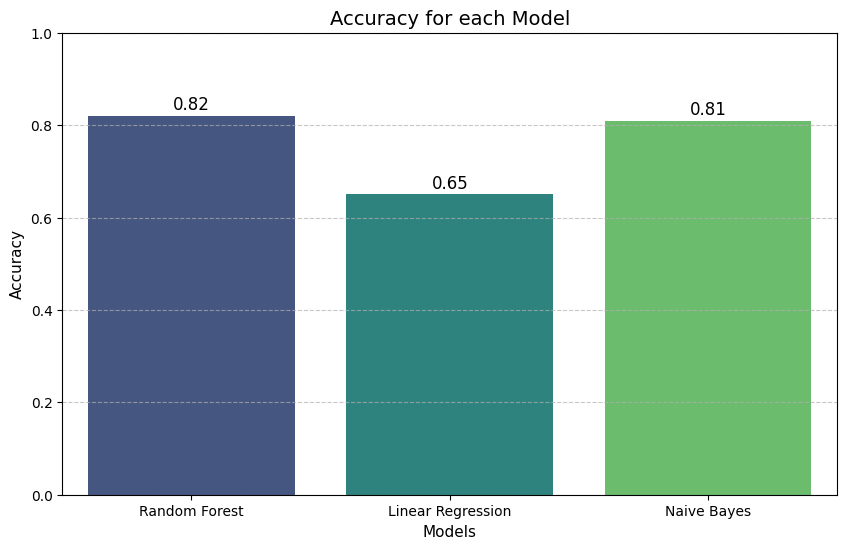

In [104]:
# Data for the graph
x_dataGraph = ['Random Forest', 'Linear Regression', 'Naive Bayes']
accuracyDataGraph = [0.82, 0.65, 0.81]

# Plot settings
plt.figure(figsize=(10, 6))
sns.barplot(x=x_dataGraph, y=accuracyDataGraph, palette="viridis", hue=x_dataGraph)
plt.title('Accuracy for each Model', fontsize=14)
plt.xlabel('Models', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.ylim(0, 1)  # Adjust the y-axis limits according to your data range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add accuracy values on top of the bars
for i, v in enumerate(accuracyDataGraph):
    plt.text(i, v + 0.005, str(v), ha='center', va='bottom', fontsize=12)

plt.show()

De nuevo, al igual que con los modelos de regresión, Naïve Bayes y Random Forest obtuvieron valores de precisión muy cercanos entre sí, ambos con valores entre 0.81 y 0.82. Además, la precisión del modelo de regresión lineal sigue siendo la más baja, con una diferencia de 0.15 en comparación los demás modelos.